In [1]:
# default_exp model

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# model1
数据: 大盘

startDate: 20100101

endDate: 2019-08-01

label: 未来10日涨幅大于5%, 跌幅大于-%5

In [11]:
startDate = '20100101'

endDate = '2019-08-01'

In [1]:
import sys
sys.path.append('..')

In [28]:
from code.datasource import SinaDataSource, stock_dict
from code.config import *
from code.visualization import draw_charts, gen_chart_data
import pandas as pd
from mylib.algo.ml.tree.catboost import train_val, predict, val
from sklearn.model_selection import train_test_split

In [3]:
ds = SinaDataSource(
#     '沪深300', 
    '大盘', 
    '20100101')

3860
code:sh000001, start_date: 20100101, end_date: 20200727, datalen: 3860
               open     high      low    close       volume
day                                                        
2010-01-04  3289.75  3295.28  3243.32  3243.76  1.09448e+10
2010-01-05  3254.47  3290.51  3221.46  3282.18  1.26115e+10
               open     high      low    close       volume
day                                                        
2020-07-23  3306.15   3336.3  3257.83  3325.11  4.07042e+10
2020-07-24  3310.64  3319.13  3184.97  3196.77  4.27054e+10


In [4]:
ds.data.shape

(2566, 55)

In [5]:
ds.data.sample(2)

open     high      low    close       volume  close_pct  \
day                                                                      
2012-05-23  2369.26  2378.08  2350.55  2363.44  8.42166e+09     -0.004   
2013-08-12  2058.42  2102.35  2055.72  2101.28  1.35129e+10      0.024   

            close_pct_log  swing  volume_pct  volume_pct_log  ...  \
day                                                           ...   
2012-05-23         -0.004 -0.012       0.097           0.092  ...   
2013-08-12          0.024  0.023       0.418           0.349  ...   

            volume_ma120_diff_pct  volume_ma120_grad1  volume_ma120_grad2  \
day                                                                         
2012-05-23                  0.041            1.003518            1.003995   
2013-08-12                  0.364            1.001563            0.996906   

            volume_ma120_grad12_diff  volume_pct_log_sum120  high_new_120  \
day                                                                         
2012-05-23                 -0.000477                  0.520           0.0   
2013-08-12                  0.004658                  0.146           0.0   

            low_new_120  close_high_new_120  close_low_new_120  swing_ma120  
day                                                                          
2012-05-23          0.0                 0.0                0.0     0.000625  
2013-08-12          0.0                 0.0                0.0    -0.001117  

[2 rows x 55 columns]

## gen_label

In [6]:
_tmp = ds.data.copy()
n = 10

def t(s):
    return s.max()/s.iloc[0]-1
_tmp['t'] = _tmp['close'].rolling(n).agg(t)


_tmp[f'label_{n}'] = 0
_tmp.loc[_tmp[f't'] >= 0.05, f'label_{n}'] = 1
_tmp[f'label_{n}'] = _tmp[f'label_{n}'].shift(-n)


def t(s):
    return s.min()/s.iloc[0]-1
_tmp['t'] = _tmp['close'].rolling(n).agg(t)
_tmp[f'label_{n}_'] = 0
_tmp.loc[_tmp[f't'] <= -0.05, f'label_{n}_'] = 1
_tmp[f'label_{n}_'] = _tmp[f'label_{n}_'].shift(-n)

_tmp = _tmp.dropna()

In [7]:
_tmp[f'label_{n}'].value_counts()

0.0    2148
1.0     287
Name: label_10, dtype: int64

In [8]:
_tmp[f'label_{n}_'].value_counts()

0.0    2164
1.0     271
Name: label_10_, dtype: int64

In [9]:
del _tmp['t']

## model1: 未来10日 涨幅大于5%

In [10]:
label_col = [
    'label_10',
    'label_10_'
#     label label1  label_1 label_0
]
cols = _tmp.drop(columns=label_col+'volume_pct close_pct open high low close volume'.split()).columns

In [12]:
X_train, X_test, y_train, y_test = (
                                _tmp.loc[_tmp.index<endDate, cols],
                                _tmp.loc[_tmp.index>=endDate, cols],
                                _tmp.loc[_tmp.index<endDate, 'label_10'],
                                _tmp.loc[_tmp.index>=endDate, 'label_10'],
                                   )

# X_train, X_test, y_train, y_test = train_test_split(
    
#     _tmp[cols], _tmp.label_10, test_size=0.1, 
#     shuffle=False)

In [13]:
cat_cols = []

{'iterations': 500, 'learning_rate': 0.05, 'random_seed': 144, 'custom_metric': 'F1', 'loss_function': 'Logloss'}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

../mylib/algo/ml/tree/catboost.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fea_ = df_features_importance.sort_values('value')[df_features_importance.value > 0].value
../mylib/algo/ml/tree/catboost.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fea_name = df_features_importance.sort_values('value')[df_features_importance.value > 0].name


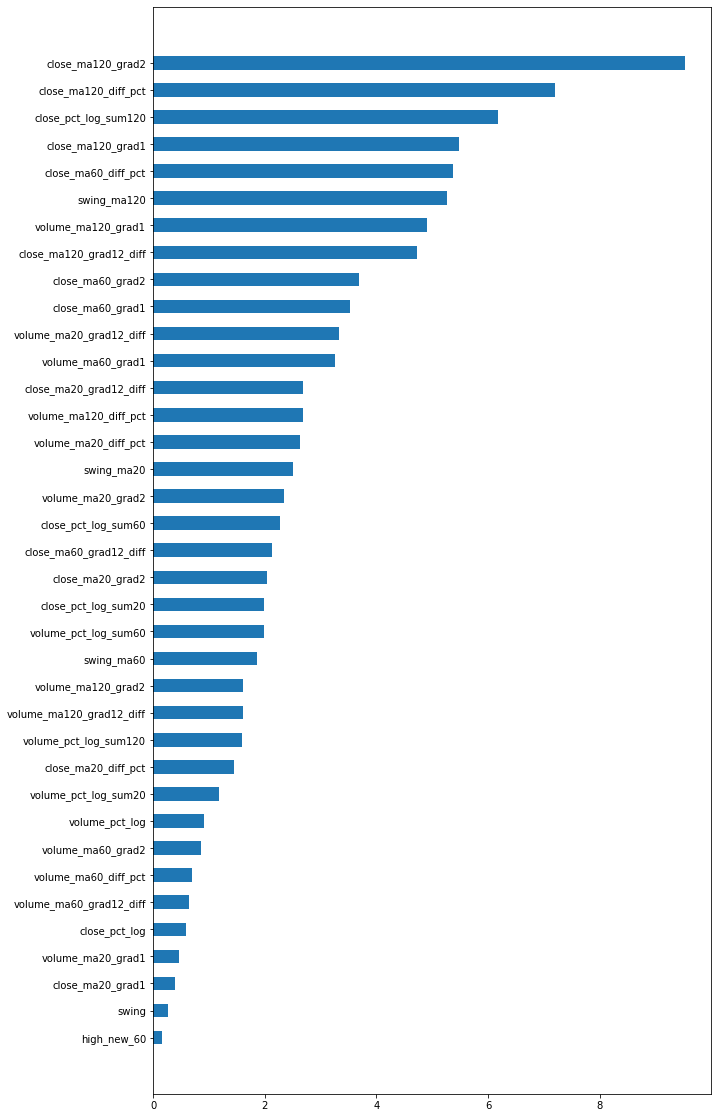

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95       209
         1.0       0.29      0.11      0.15        19

    accuracy                           0.90       228
   macro avg       0.60      0.54      0.55       228
weighted avg       0.87      0.90      0.88       228

0    221
1      7
Name: predict_label, dtype: int64
            true_label     score  predict_label  order
day                                                   
2020-07-07         0.0  0.225463              1      1
2020-02-03         1.0  0.224656              1      2
2020-07-06         0.0  0.220241              1      3
2020-02-04         1.0  0.218569              1      4
2020-07-08         0.0  0.214317              1      5
2020-07-10         0.0  0.205063              1      6
2020-07-09         0.0  0.202553              1      7
2020-02-06         1.0  0.163278              0     13
2020-02-07         1.0  0.153226              0     17
2020-07-02      

In [14]:
model1, _, _ = train_val(X_train, y_train, valset=(X_test, y_test), plot=True, threshold=0.2)

In [15]:
dfr = val(model1, _tmp[cols], _tmp.label_10, cat_cols, threshold=0.2)

              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93      2148
         1.0       0.48      0.58      0.52       287

    accuracy                           0.88      2435
   macro avg       0.71      0.75      0.73      2435
weighted avg       0.89      0.88      0.88      2435

0    2086
1     349
Name: predict_label, dtype: int64
            true_label     score  predict_label  order
day                                                   
2015-03-25         1.0  0.821125              1      1
2015-04-08         1.0  0.816805              1      2
2015-03-23         1.0  0.806133              1      3
2015-03-24         1.0  0.806133              1      4
2015-03-31         1.0  0.782523              1      5
...                ...       ...            ...    ...
2019-12-03         1.0  0.069806              0   2089
2020-06-23         1.0  0.069199              0   2121
2016-08-01         1.0  0.067447              0   2207
2020-06-16    

In [16]:
dfr = predict(model1, ds.data[cols], [], threshold=0.2)

--------------------------------------------------
0    2093
1     473
Name: predict_label, dtype: int64


In [17]:
ds.data['predict_label_1'] = dfr.predict_label

ds.data['score'] = dfr.score

In [18]:
dft = ds.data.reset_index()
ix = dft[dft.predict_label_1==1].index.tolist()
score = dft[dft.predict_label_1==1].score.tolist()
markpoints1 = list(zip(ix, score))

In [215]:
# ds_mt = SinaDataSource('sh600519', '20100101')

# dfr = predict(model1, ds_mt.data[cols], [], threshold=0.2)

# ds_mt.data['predict_label_1'] = dfr.predict_label

# ds_mt.data['score'] = dfr.score

# dft = ds_mt.data.reset_index()
# ix = dft[dft.predict_label_1==1].index.tolist()
# score = dft[dft.predict_label_1==1].score.tolist()
# markpoints1 = list(zip(ix, score))

3859
code:sh600519, start_date: 20100101, end_date: 20200726, datalen: 3859
              open   high     low   close       volume
day                                                   
2010-01-04     172    172  169.31  169.94  4.43049e+06
2010-01-05  170.99  171.5     169  169.44  3.15132e+06
               open  high   low   close       volume
day                                                 
2020-07-23     1672  1691  1650    1676  3.43205e+06
2020-07-24  1654.85  1666  1585  1595.3   7.8752e+06


## model2

In [19]:
X_train, X_test, y_train, y_test = (
                                _tmp.loc[_tmp.index<endDate, cols],
                                _tmp.loc[_tmp.index>=endDate, cols],
                                _tmp.loc[_tmp.index<endDate, 'label_10_'],
                                _tmp.loc[_tmp.index>=endDate, 'label_10_'],
                                   
                                   )

In [20]:
cat_cols = []

{'iterations': 500, 'learning_rate': 0.05, 'random_seed': 144, 'custom_metric': 'F1', 'loss_function': 'Logloss'}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

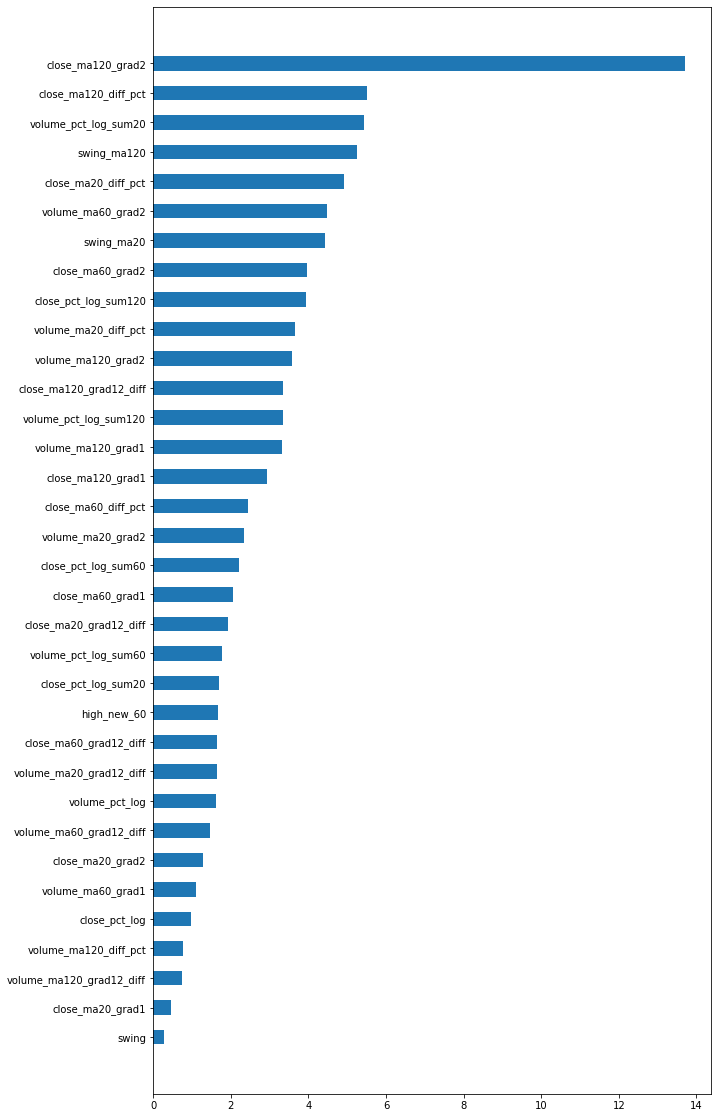

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92       205
         1.0       0.00      0.00      0.00        23

    accuracy                           0.85       228
   macro avg       0.45      0.47      0.46       228
weighted avg       0.80      0.85      0.82       228

0    216
1     12
Name: predict_label, dtype: int64
            true_label     score  predict_label  order
day                                                   
2019-10-10         0.0  0.234383              1      1
2019-09-30         0.0  0.223050              1      2
2019-10-08         0.0  0.217390              1      3
2019-10-21         0.0  0.216509              1      4
2019-10-09         0.0  0.213615              1      5
2019-08-05         0.0  0.209776              1      6
2019-09-24         0.0  0.205145              1      7
2019-09-27         0.0  0.203576              1      8
2019-10-22         0.0  0.202580              1      9
2020-03-23      

In [21]:
model2, _, _ = train_val(X_train, y_train, valset=(X_test, y_test), plot=True, threshold=0.2)

In [22]:
dfr = val(model2, _tmp[cols], _tmp.label_10, cat_cols, threshold=0.2)

              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87      2148
         1.0       0.25      0.46      0.33       287

    accuracy                           0.78      2435
   macro avg       0.59      0.64      0.60      2435
weighted avg       0.84      0.78      0.80      2435

0    1920
1     515
Name: predict_label, dtype: int64
            true_label     score  predict_label  order
day                                                   
2015-07-16         0.0  0.531244              1      1
2015-06-26         1.0  0.503798              1      2
2015-06-30         0.0  0.500303              1      3
2015-07-17         0.0  0.485910              1      4
2015-07-13         1.0  0.479188              1      5
...                ...       ...            ...    ...
2019-02-25         1.0  0.115286              0   2404
2019-02-19         1.0  0.114938              0   2405
2013-01-24         1.0  0.110335              0   2418
2019-02-21    

In [23]:
dfr = predict(model2, ds.data[cols], [], threshold=0.2)

--------------------------------------------------
0    1931
1     635
Name: predict_label, dtype: int64


In [24]:
ds.data['predict_label_1'] = dfr.predict_label

ds.data['score'] = dfr.score

In [25]:
dft = ds.data.reset_index()
ix = dft[dft.predict_label_1==1].index.tolist()
score = dft[dft.predict_label_1==1].score.tolist()
markpoints2 = list(zip(ix, score))

In [219]:
# dfr = predict(model2, ds_mt.data[cols], [], threshold=0.2)

# ds_mt.data['predict_label_1'] = dfr.predict_label

# ds_mt.data['score'] = dfr.score

# dft = ds_mt.data.reset_index()
# ix = dft[dft.predict_label_1==1].index.tolist()
# score = dft[dft.predict_label_1==1].score.tolist()
# markpoints1 = list(zip(ix, score))

--------------------------------------------------
1    1452
0    1108
Name: predict_label, dtype: int64


In [27]:
draw_charts(gen_chart_data(ds.data), markpoints1=markpoints1, markpoints2=markpoints2)

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pyecharts/charts/chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pyecharts/charts/chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pyecharts/charts/chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pyecharts/charts/composite_charts/grid.py:17: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)


## model save

In [30]:
!mkdir {args.DATA_DIR + 'model'}

In [31]:
model1.save_model(args.DATA_DIR + 'model/model1.dump')

In [32]:
model2.save_model(args.DATA_DIR + 'model/model1_.dump')

# nbexport

In [55]:
from nbdev.export import *
notebook2script('1profile.ipynb')

Converted datasource.ipynb.
